<a href="https://colab.research.google.com/github/gauthamdh/AI-ML/blob/main/Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SFL Data Challenge
### Author: Gautham Dharuman


**Problem 1**:
Here is the dataset in a comma-separated format; the goal is to create a good model to forecast PM2.5 levels in China. We ultimately would like to forecast the number of days that are high for PM2.5 levels averaged over the course of each calendar month for each city. 
 
Please provide minimally a Jupyter Notebook with your analysis. In addition, please provide a very brief write-up summarizing the problem statement, the analysis findings, and conclusions in no more than 2-4 paragraphs or adequate documentation in-notebook of the analysis.
 
**General Information**: 
Ultimately this is a time-series forecasting project where we are trying to forecast the number of days for which PM2.5 levels are high. The denotation “high” is somewhat arbitrary and is up to you to define. 
 
The dataset contains five (5) CSVs corresponding to data taken in five cities in China. Each file contains the following information:
 
* No: row number
* year: year of data in this row
* month: month of data in this row
* day: day of data in this row
* hour: hour of data in this row
* season: season of data in this row
* PM: PM2.5 concentration (ug/m^3)
* DEWP: Dew Point (Celsius Degree)
* TEMP: Temperature (Celsius Degree)
* HUMI: Humidity (%)
* PRES: Pressure (hPa)
* cbwd: Combined wind direction
* Iws: Cumulated wind speed (m/s)
* precipitation: hourly precipitation (mm)
* Iprec: Cumulated precipitation (mm)
 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import tensorflow as tf
print(tf.__version__)

2.5.0


In [134]:
# Data cleaning and processing functions
def impute_median(series):
  '''
  Fills NaNs with median value
  '''
  return series.fillna(series.median())

def impute_data_median(data, pm_list):
  '''
  Uses the impute_median() helper function to impute entries in the dataset 
  with corresponding median values
  '''
  # Loops through PM list
  for pm in pm_list:
    data[pm] = data[pm].transform(impute_median)
  # data['PM_Dongsi'] = data['PM_Dongsi'].transform(impute_median)
  # data['PM_Dongsihuan'] = data['PM_Dongsihuan'].transform(impute_median)
  # data['PM_Nongzhanguan'] = data['PM_Nongzhanguan'].transform(impute_median)
  # data['PM_US Post'] = data['PM_US Post'].transform(impute_median)
  data['HUMI'] = data['HUMI'].transform(impute_median)
  data['PRES'] = data['PRES'].transform(impute_median)
  data['TEMP'] = data['TEMP'].transform(impute_median)
  data['DEWP'] = data['DEWP'].transform(impute_median)
  data['Iws'] = data['Iws'].transform(impute_median)
  data['precipitation'] = data['precipitation'].transform(impute_median)
  data['Iprec'] = data['Iprec'].transform(impute_median)

  return data

def average_PM(data, pm_list):
  '''
  Average of the PM values
  '''
  data['PM_avg']= data[pm_list].mean(axis=1)

  return data

def average_hour(series, window_size=24):
  '''
    Averaging PM levels over 24 hours in a day
  '''
  forecast = []
  for time in range(int(len(series)/window_size)):
    forecast.append(series[time*window_size:(time + 1)*window_size].mean())

  return np.array(forecast)

# Data visualization functions
def box_plot_visualization(data,pm_list,hue):
  '''
  Box plot visualizations of different PM values 
  using a given attribute as hue
  '''
  fig,axs=plt.subplots(1,len(pm_list),figsize=(24,6))
  plt.legend(loc='best')
  for i in range(len(pm_list)):
    sns.boxplot(x='year',y=pm_list[i],data=data,ax=axs[i],hue=hue)

def dist_plot_visualization(data, pm_list):
  '''
  Dist plot visualizations of different PM values
  '''
  fig,axs=plt.subplots(1,len(pm_list)+1,figsize=(28,6))
  plt.legend(loc='best')
  sns.distplot(data['PM_avg'],ax=axs[0])
  for i in range(len(pm_list)):
    sns.distplot(data[pm_list[i]],ax=axs[i+1])

def plot_PM_time_series(data, pm_list, xlabel, ylabel, title):
  '''
  Visualization of the PM values as a time series
  '''
  plt.figure(figsize=(12,8))
  plt.plot(data['No'], data['PM_US Post'], label='PM_US post', alpha=0.3)
  plt.plot(data['No'], data['PM_avg'], label='PM_avg')
  pm_list_copy = pm_list.copy()
  pm_list_copy.remove('PM_US Post')
  for pm in pm_list_copy:
    plt.plot(data['No'], data[pm], label=pm)
  plt.legend(fontsize=12)
  plt.xlabel(xlabel, fontsize=12)
  plt.ylabel(ylabel, fontsize=12)
  plt.title(title, fontsize=12)
  plt.grid()

# Helper functions for training LSTM model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  '''
  Returns batches of shuffled window data for training
  '''
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
  '''
  Function for making predictions using the trained model
  '''
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

# A simple Conv-LSTM model
def lstm_model(num_filters,num_lsunits,num_dunits):
  '''
  Network with a single 1D Conv layer followed by an LSTM layer
  '''
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=num_filters, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    tf.keras.layers.LSTM(num_lsunits[0], return_sequences=True),
    tf.keras.layers.LSTM(num_lsunits[1], return_sequences=True),
    tf.keras.layers.Dense(num_dunits, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
  ])

  return model

## Loading and exploring Beijing data followed by training a forecasting model



In [22]:
# Loading Beijing data
fpath = '.'
data_B = pd.read_csv(fpath+'/BeijingPM20100101_20151231.csv')
data2_B = pd.read_csv(fpath+'/BeijingPM20100101_20151231.csv')
print(data_B.info())
print('\n')
print(data_B.isnull().sum())
data_B

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   No               52584 non-null  int64  
 1   year             52584 non-null  int64  
 2   month            52584 non-null  int64  
 3   day              52584 non-null  int64  
 4   hour             52584 non-null  int64  
 5   season           52584 non-null  int64  
 6   PM_Dongsi        25052 non-null  float64
 7   PM_Dongsihuan    20508 non-null  float64
 8   PM_Nongzhanguan  24931 non-null  float64
 9   PM_US Post       50387 non-null  float64
 10  DEWP             52579 non-null  float64
 11  HUMI             52245 non-null  float64
 12  PRES             52245 non-null  float64
 13  TEMP             52579 non-null  float64
 14  cbwd             52579 non-null  object 
 15  Iws              52579 non-null  float64
 16  precipitation    52100 non-null  float64
 17  Iprec       

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,52580,2015,12,31,19,4,140.0,157.0,122.0,133.0,-8.0,68.0,1031.0,-3.0,SE,7.14,0.0,0.0
52580,52581,2015,12,31,20,4,157.0,199.0,149.0,169.0,-8.0,63.0,1030.0,-2.0,SE,8.03,0.0,0.0
52581,52582,2015,12,31,21,4,171.0,231.0,196.0,203.0,-10.0,73.0,1030.0,-6.0,NE,0.89,0.0,0.0
52582,52583,2015,12,31,22,4,204.0,242.0,221.0,212.0,-10.0,73.0,1030.0,-6.0,NE,1.78,0.0,0.0


No handles with labels found to put in legend.


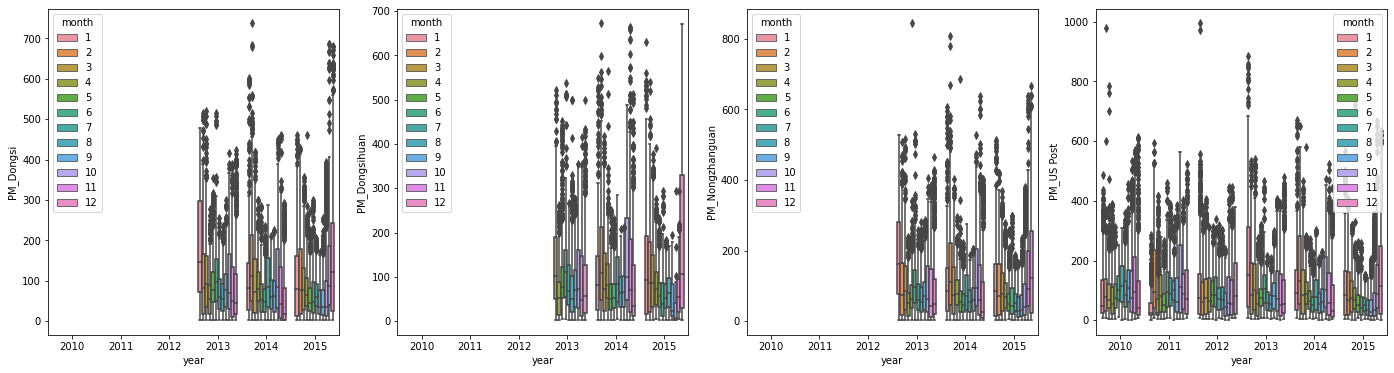

In [52]:
# Box plot visualization PM values from Beijing data
pm_list_B = ['PM_Dongsi','PM_Dongsihuan','PM_Nongzhanguan','PM_US Post']
box_plot_visualization(data_B,pm_list_B,hue='month')

#### Box plots indicate that the data is quite skewed. Therefore, it is preferrable to replace the NaNs with the corresponding median values

In [41]:
# Imputing missing PM values in Beijing data with medians
print('Checking for NaNs before imputing\n')
print(data_B.isnull().sum())
data2_B = impute_data_median(data2_B, pm_list_B)
print('Checking for NaNs after imputing\n')
print(data2_B.isnull().sum())

Checking for NaNs before imputing

No                     0
year                   0
month                  0
day                    0
hour                   0
season                 0
PM_Dongsi          27532
PM_Dongsihuan      32076
PM_Nongzhanguan    27653
PM_US Post          2197
DEWP                   5
HUMI                 339
PRES                 339
TEMP                   5
cbwd                   5
Iws                    5
precipitation        484
Iprec                484
dtype: int64
Checking for NaNs after imputing

No                 0
year               0
month              0
day                0
hour               0
season             0
PM_Dongsi          0
PM_Dongsihuan      0
PM_Nongzhanguan    0
PM_US Post         0
DEWP               0
HUMI               0
PRES               0
TEMP               0
cbwd               5
Iws                0
precipitation      0
Iprec              0
dtype: int64


In [42]:
# Adding an average PM column by averaging over all PM columns
data2_B = average_PM(data2_B, pm_list_B)
data2_B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   No               52584 non-null  int64  
 1   year             52584 non-null  int64  
 2   month            52584 non-null  int64  
 3   day              52584 non-null  int64  
 4   hour             52584 non-null  int64  
 5   season           52584 non-null  int64  
 6   PM_Dongsi        52584 non-null  float64
 7   PM_Dongsihuan    52584 non-null  float64
 8   PM_Nongzhanguan  52584 non-null  float64
 9   PM_US Post       52584 non-null  float64
 10  DEWP             52584 non-null  float64
 11  HUMI             52584 non-null  float64
 12  PRES             52584 non-null  float64
 13  TEMP             52584 non-null  float64
 14  cbwd             52579 non-null  object 
 15  Iws              52584 non-null  float64
 16  precipitation    52584 non-null  float64
 17  Iprec       

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flex

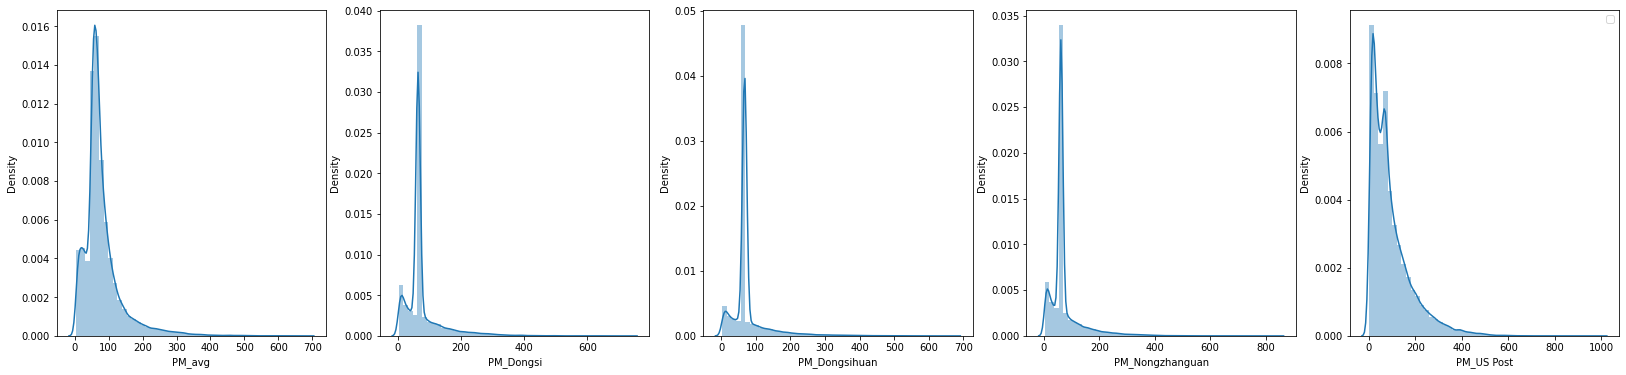

In [103]:
# Distribution plot visualization PM values from Beijing data
dist_plot_visualization(data2_B, pm_list_B)

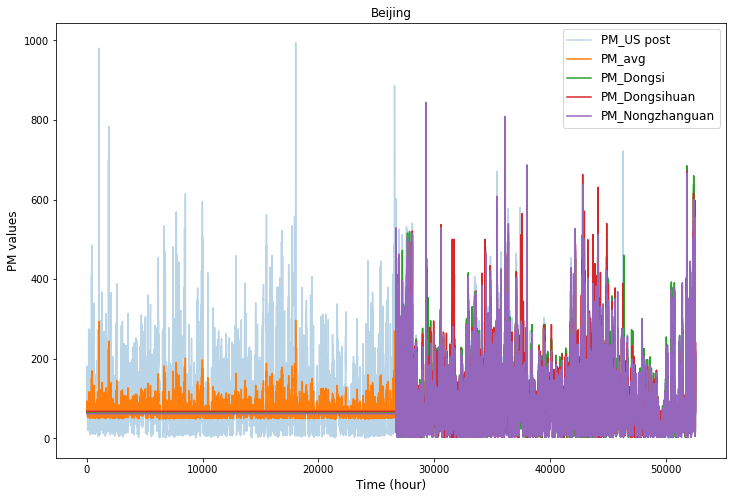

In [59]:
## Plotting all PM time series
plot_PM_time_series(data2_B, pm_list_B, xlabel='Time (hour)', ylabel='PM values', title='Beijing')

Text(0.5, 1.0, 'Beijing')

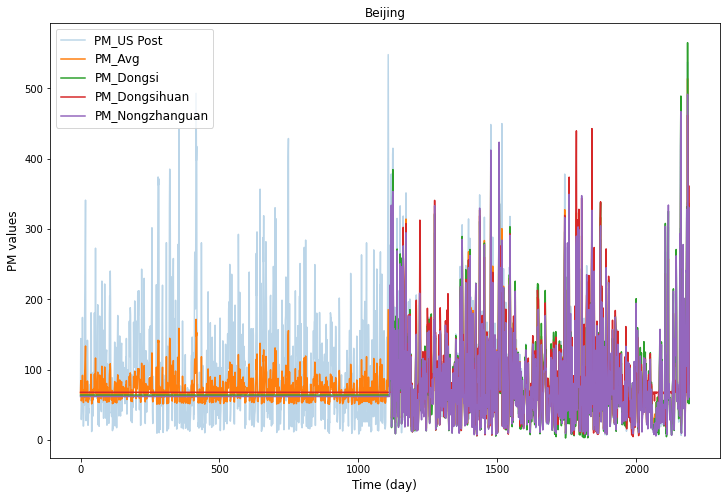

In [63]:
# Averaging PM values over 24 hours in a day
## Extracting PM values to corresponding arrays
series_avg = np.array(data2_B['PM_avg'])
series_US_post = np.array(data2_B['PM_US Post'])
series_Dongsi = np.array(data2_B['PM_Dongsi'])
series_Dongsihuan = np.array(data2_B['PM_Dongsihuan'])
series_Nongzhanguan = np.array(data2_B['PM_Nongzhanguan'])
time = np.arange(len(series_avg),dtype=int)

## PM values avergaed over a day
series_avg_d = average_hour(series_avg, 24)
series_US_post_d = average_hour(series_US_post, 24)
series_Dongsi_d = average_hour(series_Dongsi, 24)
series_Dongsihuan_d = average_hour(series_Dongsihuan, 24)
series_Nongzhanguan_d = average_hour(series_Nongzhanguan, 24)
time_d = np.arange(len(series_avg_d),dtype=int)

## Plotting PM values averaged over a day as a time series
plt.figure(figsize=(12,8))
plt.plot(time_d, series_US_post_d, label='PM_US Post',alpha=0.3)
plt.plot(time_d, series_avg_d, label='PM_Avg')
plt.plot(time_d, series_Dongsi_d, label='PM_Dongsi')
plt.plot(time_d, series_Dongsihuan_d, label='PM_Dongsihuan')
plt.plot(time_d, series_Nongzhanguan_d, label='PM_Nongzhanguan')
plt.legend(fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('PM values', fontsize=12)
plt.title('Beijing', fontsize=12)

## Training on the averaged PM time series data

In [106]:
# Preparing the training-validation dataset
split_time = 1800 
time_train = time_d[:split_time]
x_train = series_avg_d[:split_time]
time_valid = time_d[split_time:]
x_valid = series_avg_d[split_time:]

## Setting some hyperparameters for batching the window data which is fed into
## the model
window_size = 30
batch_size = 32
shuffle_buffer_size = split_time

## Getting the training and validation set
## Training set
tf.keras.backend.clear_session()
tf.random.set_seed(101)
np.random.seed(101)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)
## Validation set
shuffle_buffer_size = len(series_avg_d) - split_time
test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(test_set)
print(x_valid.shape)

## Instantiating the LSTM model
model = lstm_model(num_filters=50, num_lsunits=[60, 60], num_dunits=30)

## Compiling the model using Huber loss and SGD optimizer and MAE metric for accuracy
optimizer = tf.keras.optimizers.SGD(lr=8e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]
              )

## Training the model
history = model.fit(train_set,epochs=60, validation_data=test_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1800,)
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(391,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/60
56/56 [==============================] - 7s 58ms/step - loss: 29.1896 - mae: 29.6843 - val_loss: 43.2578 - val_mae: 43.7545
Epoch 2/60
56/56 [==============================] - 3s 42ms/step - loss: 26.0320 - mae: 26.5258 - val_loss: 41.9500 - val_mae: 42.4437
Epoch 3/60
56/56 [==============================] - 3s 41ms/step - loss: 26.2689 - mae: 26.7626 - val_loss: 43.5349 - val_mae: 44.0333
Epoch 4/60
56/56 [==============================] - 3s 42ms/step - loss: 24.8500 - mae: 25.3432 - val_loss: 41.9406 - val_mae: 42.4395
Epoch 5/60
56/56 [==============================] - 3s 42ms/step - loss: 24.6352 - mae: 25.1283 - val_loss: 39.1161 - val_mae: 39.6111
Epoch 6/60
56/56 [==============================] - 3s 44ms/step - loss: 23.8608 - mae: 24.3536 - val_loss: 38.4596 - val_mae: 38.9556
Epoch 7/60
56/56 [==============================] - 2s 41ms/step - loss: 24.2338 - mae: 24.7269 - val_loss: 37.6905 - val_mae: 38.1882
Epoch 8/60
56/56 [==============================] - 3s 

Text(0, 0.5, 'Mean Absolute Error (MAE)')

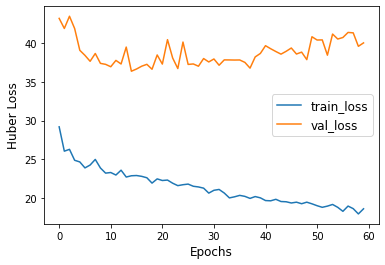

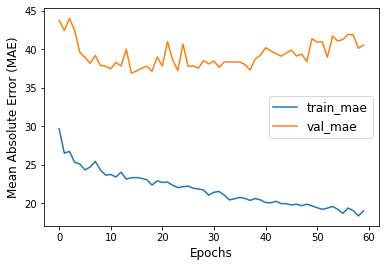

In [110]:
## Plotting training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Huber Loss', fontsize=12)

## Plotting training and validation MAE metric
plt.figure()
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)

### Suggestions for model improvement:
*   Overfitting observed can be avoided with more data (one possible solution is to train on the series with hourly resolution which will have 24 times more data points)
*   Regularization of the network
*   Tuning hyperparameters



Mean Absolute Error on the validation set =  44.49024


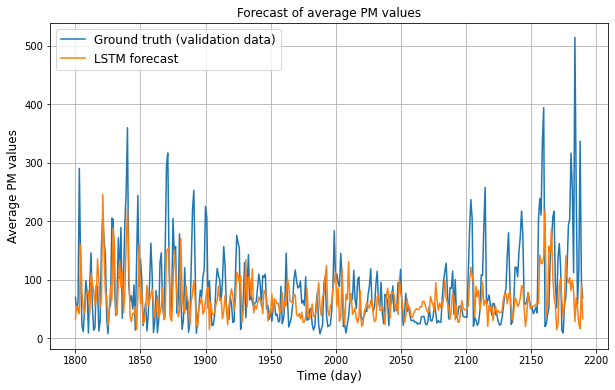

In [111]:
## Using model predictions to forecast the values in the validation set
lstm_forecast = model_forecast(model, series_avg_d[..., np.newaxis], window_size)
lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]

## Plotting model forecast against validation set
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, label='Ground truth (validation data)')
plt.plot(time_valid, lstm_forecast, label='LSTM forecast')
plt.legend(fontsize=12)
plt.grid()
plt.title('Forecast of average PM values', fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('Average PM values', fontsize=12)

mae_value_on_forecast = tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()
print('Mean Absolute Error on the validation set = ', mae_value_on_forecast)

## Forecasting number of days (in the validation set) for which averaged PM value is greater than a given threshold and comparing that forecast to ground truth

In [114]:
pm_threshold = 150
print('No. of days when PM value is forecast to be above given threshold: ', np.where(lstm_forecast > pm_threshold)[0].shape, ' days')
print('No. of days when PM value in ground truth is above given threshold: ', np.where(series_avg_d[split_time:] > pm_threshold)[0].shape, ' days')

No. of days when PM value is forecast to be above given threshold:  (15,)  days
No. of days when PM value in ground truth is above given threshold:  (52,)  days


## Model accuracy needs to be improved. With more data and regularizing the network, validation loss would get closer to the training loss thereby improving the forecast on days when average PM values are above a give threshold



---



---



# Chengudu data: Loading and exploring  followed by training a forecasting model

In [115]:
# Loading Chengdu data
fpath = '.'
city = 'Chengdu'
data = pd.read_csv(fpath+'/ChengduPM20100101_20151231.csv')
data2 = pd.read_csv(fpath+'/ChengduPM20100101_20151231.csv')
print(data.info())
print('\n')
print(data.isnull().sum())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             52584 non-null  int64  
 1   year           52584 non-null  int64  
 2   month          52584 non-null  int64  
 3   day            52584 non-null  int64  
 4   hour           52584 non-null  int64  
 5   season         52584 non-null  int64  
 6   PM_Caotangsi   24420 non-null  float64
 7   PM_Shahepu     24594 non-null  float64
 8   PM_US Post     28900 non-null  float64
 9   DEWP           52055 non-null  float64
 10  HUMI           52049 non-null  float64
 11  PRES           52063 non-null  float64
 12  TEMP           52057 non-null  float64
 13  cbwd           52063 non-null  object 
 14  Iws            52051 non-null  float64
 15  precipitation  49629 non-null  float64
 16  Iprec          49629 non-null  float64
dtypes: float64(10), int64(6), object(1)
memory usage: 

,No,year,month,day,hour,season,PM_Caotangsi,PM_Shahepu,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,4.0,81.20,1022.0,7.0,cv,1.0,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,4.0,86.99,1022.0,6.0,cv,1.0,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,4.0,86.99,1021.0,6.0,cv,1.0,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,3.0,86.89,1021.0,5.0,cv,1.0,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,2.0,86.79,1021.0,4.0,cv,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,52580,2015,12,31,19,4,176.0,225.0,262.0,7.0,87.28,1027.0,9.0,NW,2.0,0.0,0.0
52580,52581,2015,12,31,20,4,146.0,181.0,218.0,7.0,87.28,1028.0,9.0,NW,4.0,0.0,0.0
52581,52582,2015,12,31,21,4,162.0,175.0,213.0,7.0,87.28,1028.0,9.0,cv,1.0,0.0,0.0
52582,52583,2015,12,31,22,4,169.0,192.0,236.0,7.0,93.40,1028.0,8.0,NW,2.0,0.0,0.0


No handles with labels found to put in legend.


Checking for NaNs before imputing

No                   0
year                 0
month                0
day                  0
hour                 0
season               0
PM_Caotangsi     28164
PM_Shahepu       27990
PM_US Post       23684
DEWP               529
HUMI               535
PRES               521
TEMP               527
cbwd               521
Iws                533
precipitation     2955
Iprec             2955
dtype: int64
Checking for NaNs after imputing

No                 0
year               0
month              0
day                0
hour               0
season             0
PM_Caotangsi       0
PM_Shahepu         0
PM_US Post         0
DEWP               0
HUMI               0
PRES               0
TEMP               0
cbwd             521
Iws                0
precipitation      0
Iprec              0
PM_avg             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 18 columns):
 #   Column         Non-Nul

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

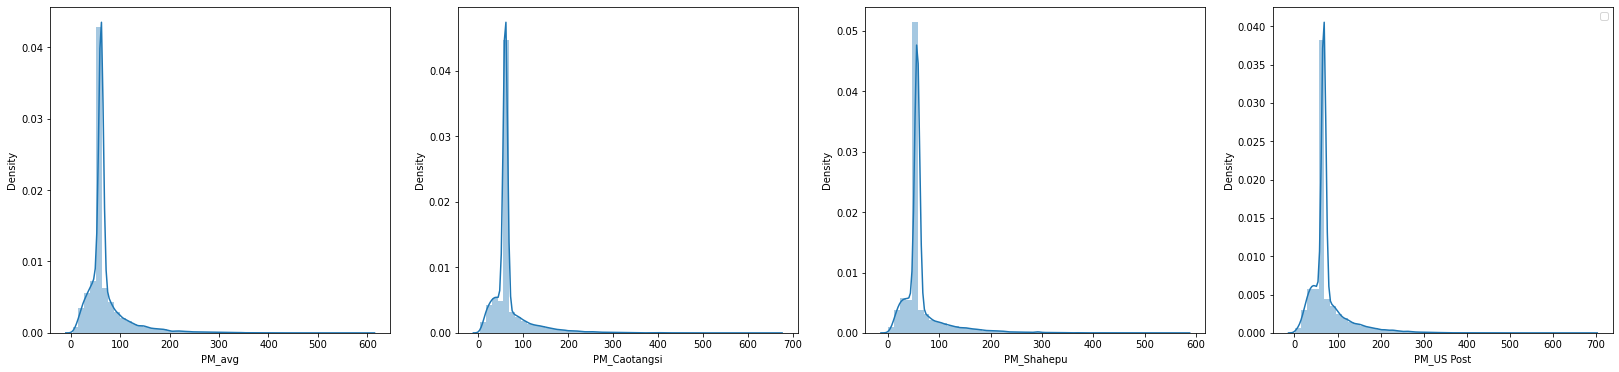

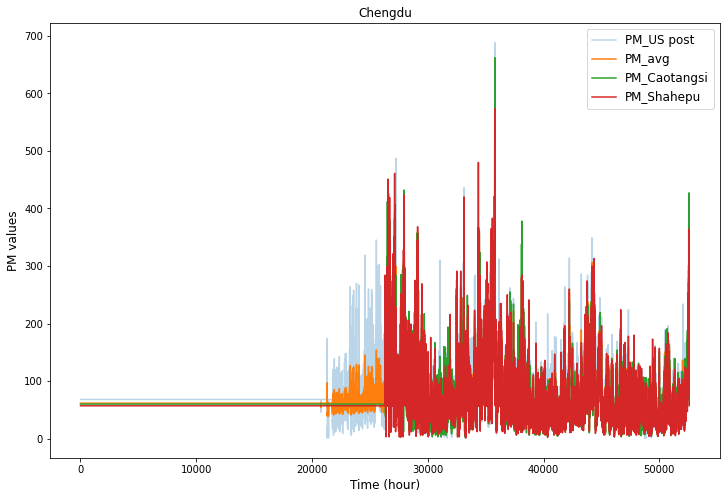

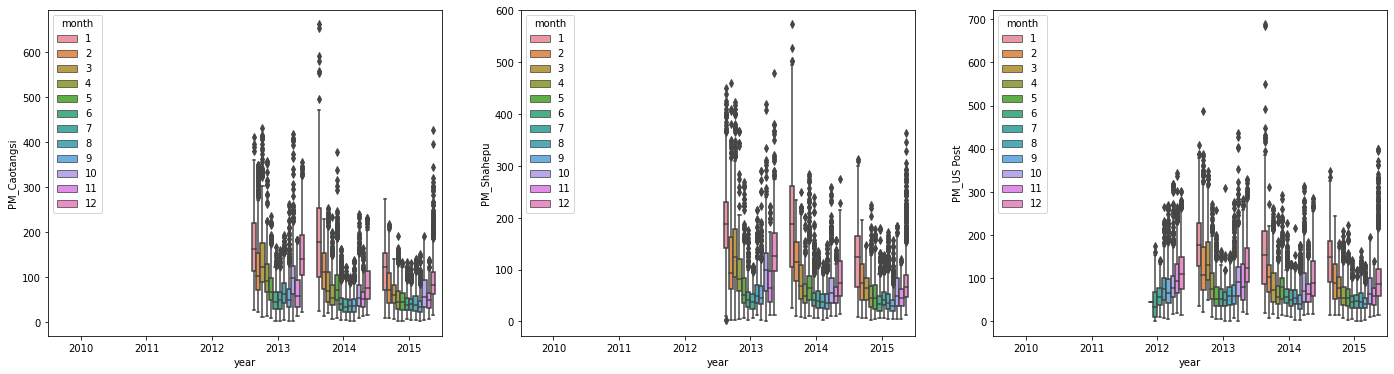

In [118]:
# Imputing missing PM values with medians
pm_list = ['PM_Caotangsi','PM_Shahepu','PM_US Post']
print('Checking for NaNs before imputing\n')
print(data.isnull().sum())
data2 = impute_data_median(data2, pm_list)
print('Checking for NaNs after imputing\n')
print(data2.isnull().sum())

# Adding an average PM column by averaging over all PM columns
data2 = average_PM(data2, pm_list)
data2.info()

# Distribution plot visualization PM values from Beijing data
dist_plot_visualization(data2, pm_list)

## Plotting all PM time series
plot_PM_time_series(data2, pm_list, xlabel='Time (hour)', ylabel='PM values', title=city)

# Box plot visualization PM values by the month before imputing
box_plot_visualization(data,pm_list,hue='month')

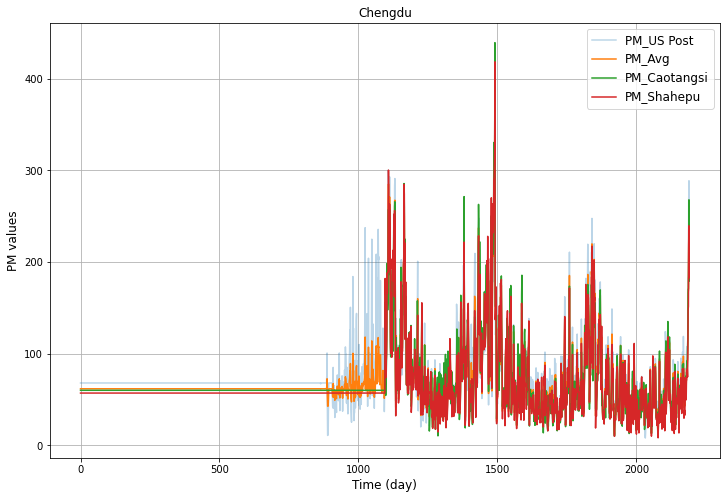

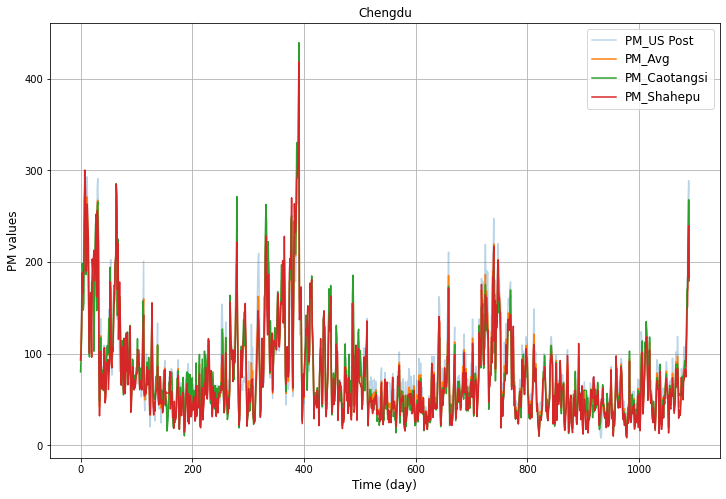

In [123]:
# Averaging PM values over 24 hours in a day
## Extracting PM values to corresponding arrays
series_avg = np.array(data2['PM_avg'])
series_US_post = np.array(data2['PM_US Post'])
series_Caotangsi = np.array(data2['PM_Caotangsi'])
series_Shahepu = np.array(data2['PM_Shahepu'])
time = np.arange(len(series_avg),dtype=int)

## PM values avergaed over a day
series_avg_d = average_hour(series_avg, 24)
series_US_post_d = average_hour(series_US_post, 24)
series_Caotangsi_d = average_hour(series_Caotangsi, 24)
series_Shahepu_d = average_hour(series_Shahepu, 24)
time_d = np.arange(len(series_avg_d),dtype=int)

## Plotting PM values averaged over a day as a time series
plt.figure(figsize=(12,8))
plt.plot(time_d, series_US_post_d, label='PM_US Post',alpha=0.3)
plt.plot(time_d, series_avg_d, label='PM_Avg')
plt.plot(time_d, series_Caotangsi_d, label='PM_Caotangsi')
plt.plot(time_d, series_Shahepu_d, label='PM_Shahepu')
plt.legend(fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('PM values', fontsize=12)
plt.title(city, fontsize=12)
plt.grid()

## Using PM values only from the later period
start = 1100
series_US_post_d = series_US_post_d[start:]
series_avg_d = series_avg_d[start:]
series_Caotangsi_d = series_Caotangsi_d[start:]
series_Shahepu_d = series_Shahepu_d[start:]
time_d = np.arange(len(series_avg_d))
## Plotting PM values for the later period
plt.figure(figsize=(12,8))
plt.plot(time_d, series_US_post_d, label='PM_US Post',alpha=0.3)
plt.plot(time_d, series_avg_d, label='PM_Avg')
plt.plot(time_d, series_Caotangsi_d, label='PM_Caotangsi')
plt.plot(time_d, series_Shahepu_d, label='PM_Shahepu')
plt.legend(fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('PM values', fontsize=12)
plt.title(city, fontsize=12)
plt.grid()

In [124]:
# Preparing the training-validation dataset
split_time = 800 
time_train = time_d[:split_time]
x_train = series_avg_d[:split_time]
time_valid = time_d[split_time:]
x_valid = series_avg_d[split_time:]

## Setting some hyperparameters for batching the window data which is fed into
## the model
window_size = 30
batch_size = 32
shuffle_buffer_size = split_time

## Getting the training and validation set
## Training set
tf.keras.backend.clear_session()
tf.random.set_seed(101)
np.random.seed(101)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)
## Validation set
shuffle_buffer_size = len(series_avg_d) - split_time
test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(test_set)
print(x_valid.shape)

## Instantiating the LSTM model
model = lstm_model(num_filters=50, num_lsunits=[60, 60], num_dunits=30)

## Compiling the model using Huber loss and SGD optimizer and MAE metric for accuracy
optimizer = tf.keras.optimizers.SGD(lr=8e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]
              )

## Training the model
history = model.fit(train_set,epochs=60, validation_data=test_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(800,)
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(291,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/60
25/25 [==============================] - 6s 83ms/step - loss: 39.6957 - mae: 40.1927 - val_loss: 18.0824 - val_mae: 18.5769
Epoch 2/60
25/25 [==============================] - 1s 44ms/step - loss: 34.7992 - mae: 35.2959 - val_loss: 62.1923 - val_mae: 62.6919
Epoch 3/60
25/25 [==============================] - 1s 44ms/step - loss: 39.2700 - mae: 39.7672 - val_loss: 23.9465 - val_mae: 24.4432
Epoch 4/60
25/25 [==============================] - 1s 45ms/step - loss: 33.0135 - mae: 33.5088 - val_loss: 41.0875 - val_mae: 41.5865
Epoch 5/60
25/25 [==============================] - 1s 44ms/step - loss: 36.4591 - mae: 36.9556 - val_loss: 20.9769 - val_mae: 21.4738
Epoch 6/60
25/25 [==============================] - 1s 45ms/step - loss: 30.7172 - mae: 31.2131 - val_loss: 16.6790 - val_mae: 17.1727
Epoch 7/60
25/25 [==============================] - 1s 46ms/step - loss: 35.4803 - mae: 35.9768 - val_loss: 17.3507 - val_mae: 17.8447
Epoch 8/60
25/25 [==============================] - 1s 

Text(0, 0.5, 'Mean Absolute Error (MAE)')

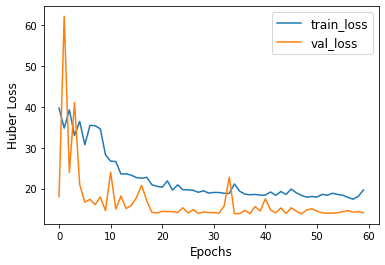

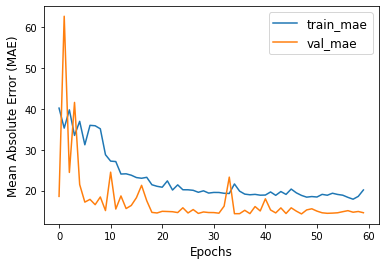

In [125]:
## Plotting training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Huber Loss', fontsize=12)

## Plotting training and validation MAE metric
plt.figure()
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)

Mean Absolute Error on the validation set =  16.288383


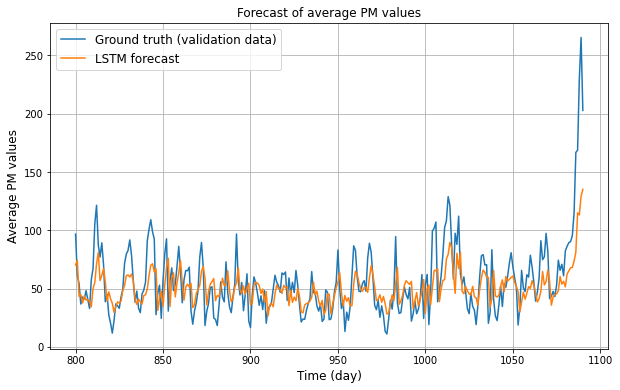

In [128]:
## Using model predictions to forecast the values in the validation set
lstm_forecast = model_forecast(model, series_avg_d[..., np.newaxis], window_size)
lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]

## Plotting model forecast against validation set
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, label='Ground truth (validation data)')
plt.plot(time_valid, lstm_forecast, label='LSTM forecast')
plt.legend(fontsize=12)
plt.grid()
plt.title('Forecast of average PM values', fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('Average PM values', fontsize=12)

mae_value_on_forecast = tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()
print('Mean Absolute Error on the validation set = ', mae_value_on_forecast)

In [129]:
pm_threshold = 75
print('No. of days when PM value is forecast to be above given threshold: ', np.where(lstm_forecast > pm_threshold)[0].shape, ' days')
print('No. of days when PM value in ground truth is above given threshold: ', np.where(series_avg_d[split_time:] > pm_threshold)[0].shape, ' days')

No. of days when PM value is forecast to be above given threshold:  (13,)  days
No. of days when PM value in ground truth is above given threshold:  (60,)  days




---



# Guangzhou data: Loading and exploring  followed by training a forecasting model

In [132]:
# Loading Guangzhou data
fpath = '.'
city = 'Guangzhou'
data = pd.read_csv(fpath+'/GuangzhouPM20100101_20151231.csv')
data2 = pd.read_csv(fpath+'/GuangzhouPM20100101_20151231.csv')
print(data.info())
print('\n')
print(data.isnull().sum())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   No                    52584 non-null  int64  
 1   year                  52584 non-null  int64  
 2   month                 52584 non-null  int64  
 3   day                   52584 non-null  int64  
 4   hour                  52584 non-null  int64  
 5   season                52583 non-null  float64
 6   PM_City Station       32352 non-null  float64
 7   PM_5th Middle School  21095 non-null  float64
 8   PM_US Post            32352 non-null  float64
 9   DEWP                  52583 non-null  float64
 10  HUMI                  52583 non-null  float64
 11  PRES                  52583 non-null  float64
 12  TEMP                  52583 non-null  float64
 13  cbwd                  52583 non-null  object 
 14  Iws                   52583 non-null  float64
 15  precipitation      

,No,year,month,day,hour,season,PM_City Station,PM_5th Middle School,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4.0,NaN,NaN,NaN,9.4,76.0,1015.100000,13.5,NW,0.8,0.0,0.0
1,2,2010,1,1,1,4.0,NaN,NaN,NaN,10.2,83.0,1015.200000,13.0,cv,0.5,0.0,0.0
2,3,2010,1,1,2,4.0,NaN,NaN,NaN,10.4,87.0,1015.000000,12.5,NW,0.6,0.3,0.3
3,4,2010,1,1,3,4.0,NaN,NaN,NaN,10.2,89.0,1014.900000,12.0,NW,1.4,0.6,0.9
4,5,2010,1,1,4,4.0,NaN,NaN,NaN,10.4,91.0,1014.600000,11.8,NE,0.6,0.7,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,52580,2015,12,31,19,4.0,59.0,56.0,59.0,11.0,80.0,1018.299988,14.4,NW,10.9,0.0,0.0
52580,52581,2015,12,31,20,4.0,58.0,57.0,58.0,11.4,82.0,1018.700012,14.5,NW,12.9,0.0,0.0
52581,52582,2015,12,31,21,4.0,60.0,56.0,60.0,11.1,78.0,1019.300000,14.9,NW,14.7,0.0,0.0
52582,52583,2015,12,31,22,4.0,60.0,57.0,60.0,10.4,75.0,1019.500000,14.8,NW,15.9,0.0,0.0


Checking for NaNs before imputing

No                          0
year                        0
month                       0
day                         0
hour                        0
season                      1
PM_City Station         20232
PM_5th Middle School    31489
PM_US Post              20232
DEWP                        1
HUMI                        1
PRES                        1
TEMP                        1
cbwd                        1
Iws                         1
precipitation               1
Iprec                       1
dtype: int64
Checking for NaNs after imputing

No                      0
year                    0
month                   0
day                     0
hour                    0
season                  1
PM_City Station         0
PM_5th Middle School    0
PM_US Post              0
DEWP                    0
HUMI                    0
PRES                    0
TEMP                    0
cbwd                    1
Iws                     0
precipitation     

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flex

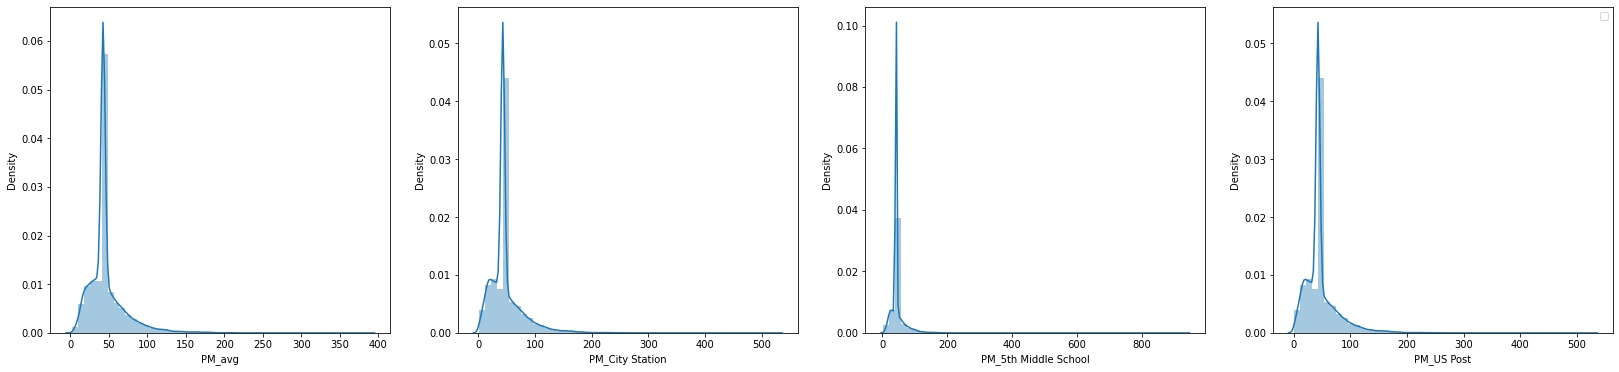

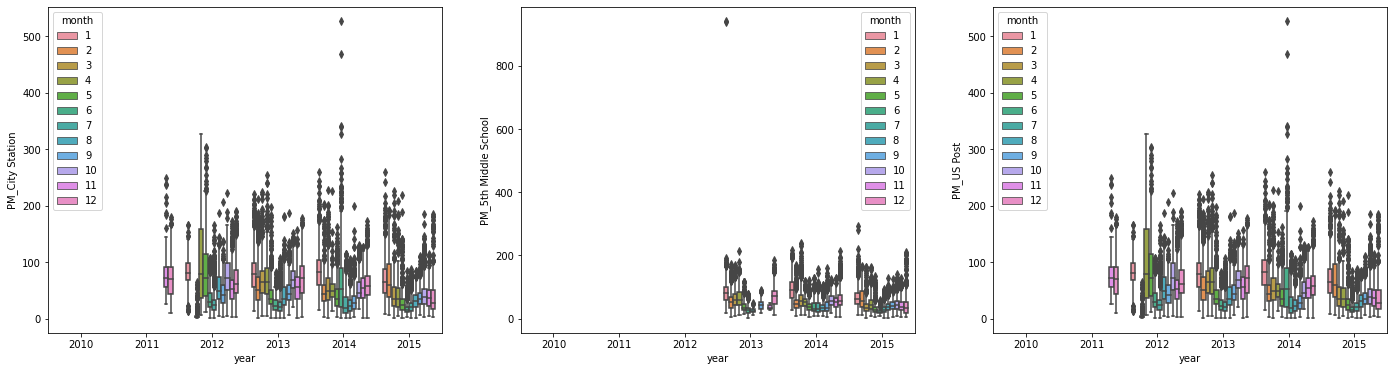

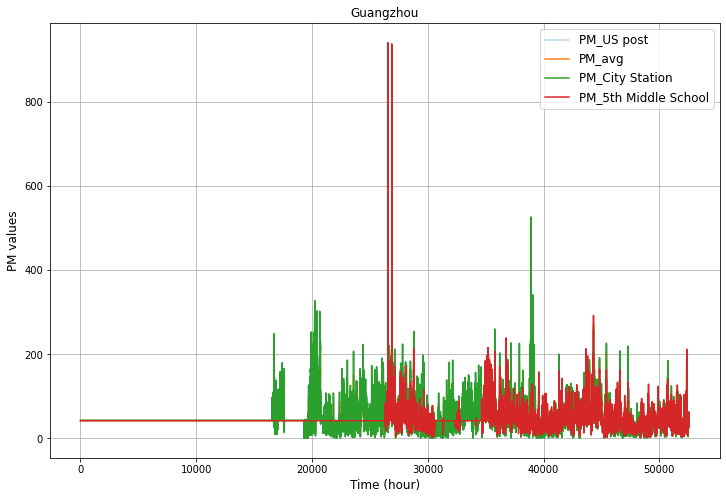

In [135]:
# Imputing missing PM values with medians
pm_list = ['PM_City Station','PM_5th Middle School','PM_US Post']
print('Checking for NaNs before imputing\n')
print(data.isnull().sum())
data2 = impute_data_median(data2, pm_list)
print('Checking for NaNs after imputing\n')
print(data2.isnull().sum())

# Adding an average PM column by averaging over all PM columns
data2 = average_PM(data2, pm_list)
data2.info()

# Distribution plot visualization PM values from Beijing data
dist_plot_visualization(data2, pm_list)

# Box plot visualization PM values by the month before imputing
box_plot_visualization(data,pm_list,hue='month')

## Plotting all PM time series
plot_PM_time_series(data2, pm_list, xlabel='Time (hour)', ylabel='PM values', title=city)

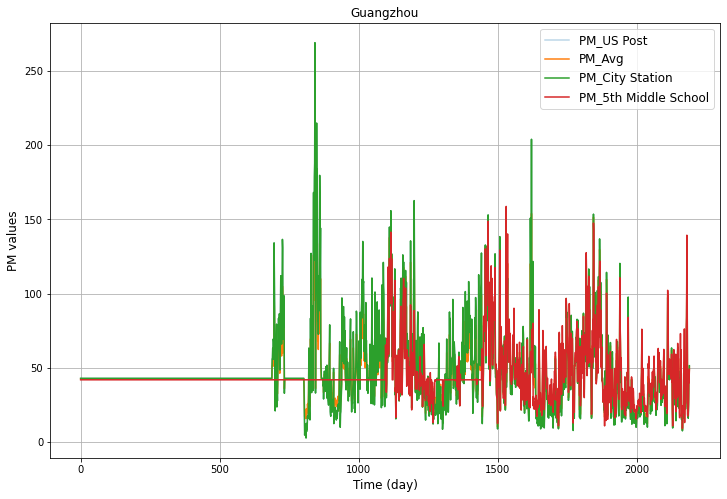

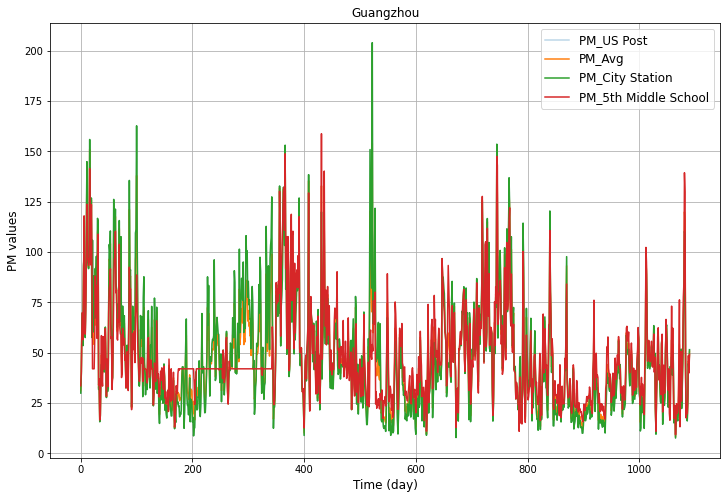

In [137]:
# Averaging PM values over 24 hours in a day
## Extracting PM values to corresponding arrays
series_avg = np.array(data2['PM_avg'])
series_US_post = np.array(data2['PM_US Post'])
series_Citystation = np.array(data2['PM_City Station'])
series_School = np.array(data2['PM_5th Middle School'])
time = np.arange(len(series_avg),dtype=int)

## PM values avergaed over a day
series_avg_d = average_hour(series_avg, 24)
series_US_post_d = average_hour(series_US_post, 24)
series_Citystation_d = average_hour(series_Citystation, 24)
series_School_d = average_hour(series_School, 24)
time_d = np.arange(len(series_avg_d),dtype=int)

## Plotting PM values averaged over a day as a time series
plt.figure(figsize=(12,8))
plt.plot(time_d, series_US_post_d, label='PM_US Post',alpha=0.3)
plt.plot(time_d, series_avg_d, label='PM_Avg')
plt.plot(time_d, series_Citystation_d, label='PM_City Station')
plt.plot(time_d, series_School_d, label='PM_5th Middle School')
plt.legend(fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('PM values', fontsize=12)
plt.title(city, fontsize=12)
plt.grid()

## Using PM values only from the later period
start = 1100
series_US_post_d = series_US_post_d[start:]
series_avg_d = series_avg_d[start:]
series_Citystation_d = series_Citystation_d[start:]
series_School_d = series_School_d[start:]
time_d = np.arange(len(series_avg_d))
## Plotting PM values for the later period
plt.figure(figsize=(12,8))
plt.plot(time_d, series_US_post_d, label='PM_US Post',alpha=0.3)
plt.plot(time_d, series_avg_d, label='PM_Avg')
plt.plot(time_d, series_Citystation_d, label='PM_City Station')
plt.plot(time_d, series_School_d, label='PM_5th Middle School')
plt.legend(fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('PM values', fontsize=12)
plt.title(city, fontsize=12)
plt.grid()

In [138]:
# Preparing the training-validation dataset
split_time = 800 
time_train = time_d[:split_time]
x_train = series_avg_d[:split_time]
time_valid = time_d[split_time:]
x_valid = series_avg_d[split_time:]

## Setting some hyperparameters for batching the window data which is fed into
## the model
window_size = 30
batch_size = 32
shuffle_buffer_size = split_time

## Getting the training and validation set
## Training set
tf.keras.backend.clear_session()
tf.random.set_seed(101)
np.random.seed(101)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)
## Validation set
shuffle_buffer_size = len(series_avg_d) - split_time
test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(test_set)
print(x_valid.shape)

## Instantiating the LSTM model
model = lstm_model(num_filters=50, num_lsunits=[60, 60], num_dunits=30)

## Compiling the model using Huber loss and SGD optimizer and MAE metric for accuracy
optimizer = tf.keras.optimizers.SGD(lr=8e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]
              )

## Training the model
history = model.fit(train_set,epochs=60, validation_data=test_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(800,)
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(291,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/60
25/25 [==============================] - 6s 86ms/step - loss: 28.9759 - mae: 29.4724 - val_loss: 11.2583 - val_mae: 11.7511
Epoch 2/60
25/25 [==============================] - 1s 44ms/step - loss: 17.8529 - mae: 18.3471 - val_loss: 24.6508 - val_mae: 25.1482
Epoch 3/60
25/25 [==============================] - 1s 45ms/step - loss: 19.2755 - mae: 19.7702 - val_loss: 10.8328 - val_mae: 11.3260
Epoch 4/60
25/25 [==============================] - 1s 46ms/step - loss: 16.1803 - mae: 16.6734 - val_loss: 25.8746 - val_mae: 26.3732
Epoch 5/60
25/25 [==============================] - 1s 46ms/step - loss: 16.8279 - mae: 17.3216 - val_loss: 16.2220 - val_mae: 16.7166
Epoch 6/60
25/25 [==============================] - 1s 46ms/step - loss: 15.7610 - mae: 16.2541 - val_loss: 10.2953 - val_mae: 10.7862
Epoch 7/60
25/25 [==============================] - 1s 48ms/step - loss: 14.5785 - mae: 15.0702 - val_loss: 12.1492 - val_mae: 12.6399
Epoch 8/60
25/25 [==============================] - 1s 

Text(0, 0.5, 'Mean Absolute Error (MAE)')

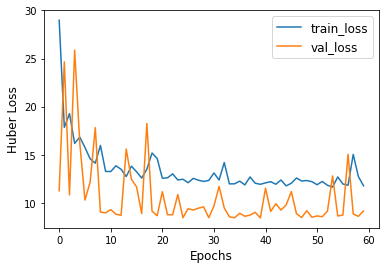

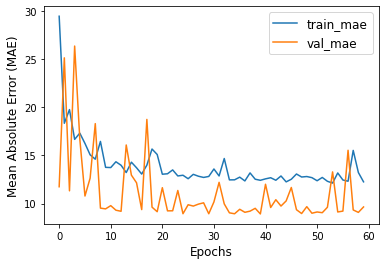

In [139]:
## Plotting training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Huber Loss', fontsize=12)

## Plotting training and validation MAE metric
plt.figure()
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)

Mean Absolute Error on the validation set =  10.033546


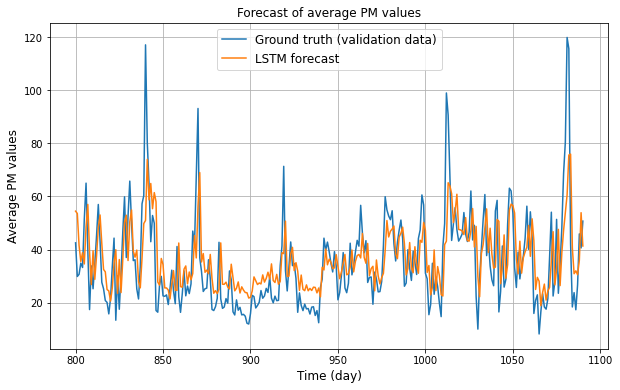

In [140]:
## Using model predictions to forecast the values in the validation set
lstm_forecast = model_forecast(model, series_avg_d[..., np.newaxis], window_size)
lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]

## Plotting model forecast against validation set
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, label='Ground truth (validation data)')
plt.plot(time_valid, lstm_forecast, label='LSTM forecast')
plt.legend(fontsize=12)
plt.grid()
plt.title('Forecast of average PM values', fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('Average PM values', fontsize=12)

mae_value_on_forecast = tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()
print('Mean Absolute Error on the validation set = ', mae_value_on_forecast)

In [141]:
pm_threshold = 50
print('No. of days when PM value is forecast to be above given threshold: ', np.where(lstm_forecast > pm_threshold)[0].shape, ' days')
print('No. of days when PM value in ground truth is above given threshold: ', np.where(series_avg_d[split_time:] > pm_threshold)[0].shape, ' days')

No. of days when PM value is forecast to be above given threshold:  (41,)  days
No. of days when PM value in ground truth is above given threshold:  (47,)  days




---



# Shanghai data: Loading and exploring  followed by training a forecasting model

In [142]:
# Loading Shanghai data
fpath = '.'
city = 'Shanghai'
data = pd.read_csv(fpath+'/ShanghaiPM20100101_20151231.csv')
data2 = pd.read_csv(fpath+'/ShanghaiPM20100101_20151231.csv')
print(data.info())
print('\n')
print(data.isnull().sum())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             52584 non-null  int64  
 1   year           52584 non-null  int64  
 2   month          52584 non-null  int64  
 3   day            52584 non-null  int64  
 4   hour           52584 non-null  int64  
 5   season         52584 non-null  int64  
 6   PM_Jingan      24700 non-null  float64
 7   PM_US Post     34039 non-null  float64
 8   PM_Xuhui       25189 non-null  float64
 9   DEWP           52571 non-null  float64
 10  HUMI           52571 non-null  float64
 11  PRES           52556 non-null  float64
 12  TEMP           52571 non-null  float64
 13  cbwd           52572 non-null  object 
 14  Iws            52572 non-null  float64
 15  precipitation  48575 non-null  float64
 16  Iprec          48575 non-null  float64
dtypes: float64(10), int64(6), object(1)
memory usage: 

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,-6.0,59.48,1026.1,1.0,cv,1.0,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,-6.0,59.48,1025.1,1.0,SE,2.0,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,-7.0,59.21,1025.1,0.0,SE,4.0,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,-6.0,63.94,1024.0,0.0,SE,5.0,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,-6.0,63.94,1023.0,0.0,SE,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,52580,2015,12,31,19,4,86.0,82.0,90.0,-1.0,65.13,1035.0,5.0,NE,15.0,0.0,0.0
52580,52581,2015,12,31,20,4,83.0,93.0,86.0,1.0,70.27,1035.0,6.0,NE,19.0,0.0,0.0
52581,52582,2015,12,31,21,4,85.0,90.0,95.0,1.0,70.27,1036.0,6.0,NE,22.0,0.0,0.0
52582,52583,2015,12,31,22,4,83.0,86.0,92.0,0.0,70.06,1035.0,5.0,NE,25.0,0.0,0.0


No handles with labels found to put in legend.


Checking for NaNs before imputing

No                   0
year                 0
month                0
day                  0
hour                 0
season               0
PM_Jingan        27884
PM_US Post       18545
PM_Xuhui         27395
DEWP                13
HUMI                13
PRES                28
TEMP                13
cbwd                12
Iws                 12
precipitation     4009
Iprec             4009
dtype: int64
Checking for NaNs after imputing

No                0
year              0
month             0
day               0
hour              0
season            0
PM_Jingan         0
PM_US Post        0
PM_Xuhui          0
DEWP              0
HUMI              0
PRES              0
TEMP              0
cbwd             12
Iws               0
precipitation     0
Iprec             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         -

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

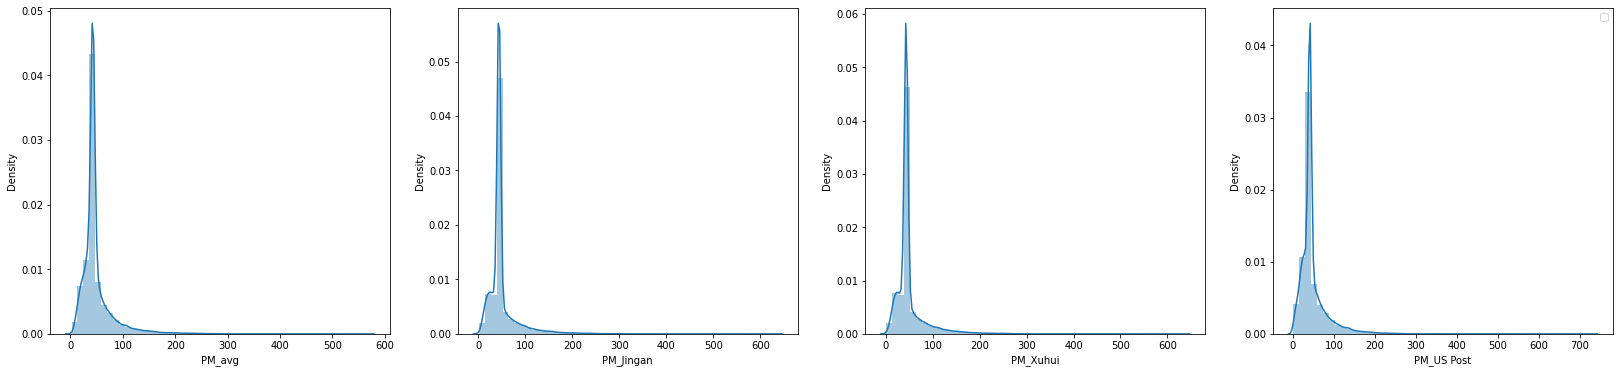

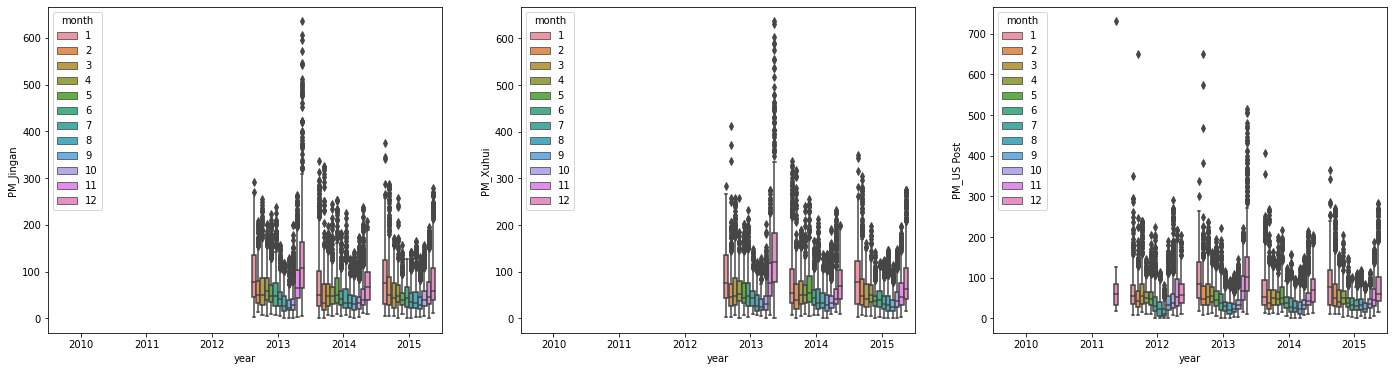

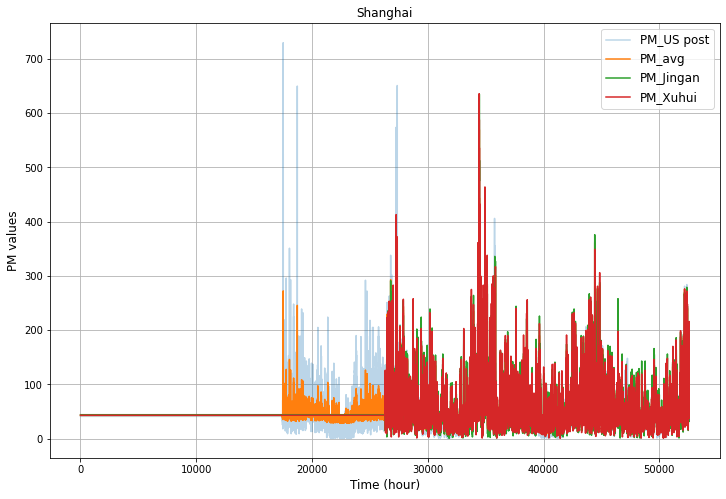

In [143]:
# Imputing missing PM values with medians
pm_list = ['PM_Jingan','PM_Xuhui','PM_US Post']
print('Checking for NaNs before imputing\n')
print(data.isnull().sum())
data2 = impute_data_median(data2, pm_list)
print('Checking for NaNs after imputing\n')
print(data2.isnull().sum())

# Adding an average PM column by averaging over all PM columns
data2 = average_PM(data2, pm_list)
data2.info()

# Distribution plot visualization PM values from Beijing data
dist_plot_visualization(data2, pm_list)

# Box plot visualization PM values by the month before imputing
box_plot_visualization(data,pm_list,hue='month')

## Plotting all PM time series
plot_PM_time_series(data2, pm_list, xlabel='Time (hour)', ylabel='PM values', title=city)

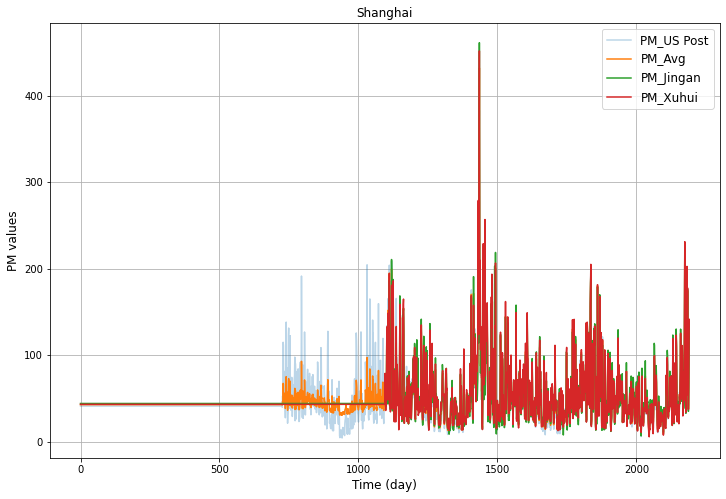

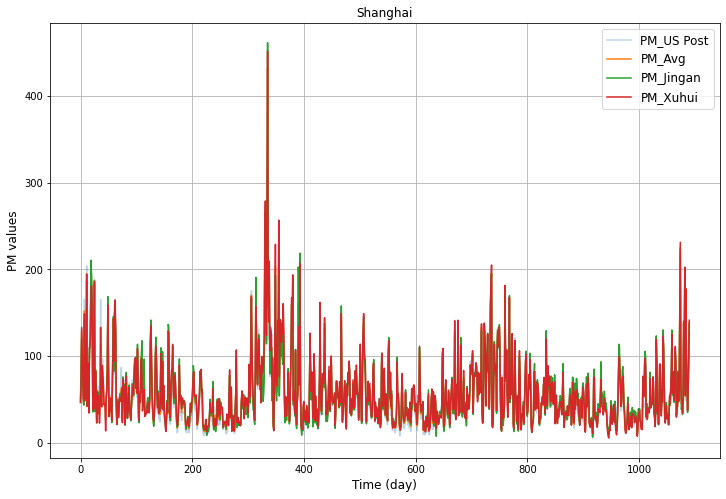

In [144]:
# Averaging PM values over 24 hours in a day
## Extracting PM values to corresponding arrays
series_avg = np.array(data2['PM_avg'])
series_US_post = np.array(data2['PM_US Post'])
series_Jingan = np.array(data2['PM_Jingan'])
series_Xuhui = np.array(data2['PM_Xuhui'])
time = np.arange(len(series_avg),dtype=int)

## PM values avergaed over a day
series_avg_d = average_hour(series_avg, 24)
series_US_post_d = average_hour(series_US_post, 24)
series_Jingan_d = average_hour(series_Jingan, 24)
series_Xuhui_d = average_hour(series_Xuhui, 24)
time_d = np.arange(len(series_avg_d),dtype=int)

## Plotting PM values averaged over a day as a time series
plt.figure(figsize=(12,8))
plt.plot(time_d, series_US_post_d, label='PM_US Post',alpha=0.3)
plt.plot(time_d, series_avg_d, label='PM_Avg')
plt.plot(time_d, series_Jingan_d, label='PM_Jingan')
plt.plot(time_d, series_Xuhui_d, label='PM_Xuhui')
plt.legend(fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('PM values', fontsize=12)
plt.title(city, fontsize=12)
plt.grid()

## Using PM values only from the later period
start = 1100
series_US_post_d = series_US_post_d[start:]
series_avg_d = series_avg_d[start:]
series_Jingan_d = series_Jingan_d[start:]
series_Xuhui_d = series_Xuhui_d[start:]
time_d = np.arange(len(series_avg_d))
## Plotting PM values for the later period
plt.figure(figsize=(12,8))
plt.plot(time_d, series_US_post_d, label='PM_US Post',alpha=0.3)
plt.plot(time_d, series_avg_d, label='PM_Avg')
plt.plot(time_d, series_Jingan_d, label='PM_Jingan')
plt.plot(time_d, series_Xuhui_d, label='PM_Xuhui')
plt.legend(fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('PM values', fontsize=12)
plt.title(city, fontsize=12)
plt.grid()

In [145]:
# Preparing the training-validation dataset
split_time = 800 
time_train = time_d[:split_time]
x_train = series_avg_d[:split_time]
time_valid = time_d[split_time:]
x_valid = series_avg_d[split_time:]

## Setting some hyperparameters for batching the window data which is fed into
## the model
window_size = 30
batch_size = 32
shuffle_buffer_size = split_time

## Getting the training and validation set
## Training set
tf.keras.backend.clear_session()
tf.random.set_seed(101)
np.random.seed(101)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)
## Validation set
shuffle_buffer_size = len(series_avg_d) - split_time
test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(test_set)
print(x_valid.shape)

## Instantiating the LSTM model
model = lstm_model(num_filters=50, num_lsunits=[60, 60], num_dunits=30)

## Compiling the model using Huber loss and SGD optimizer and MAE metric for accuracy
optimizer = tf.keras.optimizers.SGD(lr=8e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]
              )

## Training the model
history = model.fit(train_set,epochs=60, validation_data=test_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(800,)
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(291,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/60
25/25 [==============================] - 6s 84ms/step - loss: 31.3949 - mae: 31.8910 - val_loss: 15.7484 - val_mae: 16.2389
Epoch 2/60
25/25 [==============================] - 1s 45ms/step - loss: 24.0069 - mae: 24.5015 - val_loss: 16.9768 - val_mae: 17.4720
Epoch 3/60
25/25 [==============================] - 1s 43ms/step - loss: 23.8357 - mae: 24.3302 - val_loss: 23.5031 - val_mae: 23.9998
Epoch 4/60
25/25 [==============================] - 1s 45ms/step - loss: 23.7086 - mae: 24.2030 - val_loss: 35.2938 - val_mae: 35.7925
Epoch 5/60
25/25 [==============================] - 1s 43ms/step - loss: 26.5672 - mae: 27.0623 - val_loss: 20.6598 - val_mae: 21.1557
Epoch 6/60
25/25 [==============================] - 1s 43ms/step - loss: 23.1508 - mae: 23.6454 - val_loss: 14.5885 - val_mae: 15.0794
Epoch 7/60
25/25 [==============================] - 1s 43ms/step - loss: 22.2244 - mae: 22.7184 - val_loss: 14.4796 - val_mae: 14.9716
Epoch 8/60
25/25 [==============================] - 1s 

Text(0, 0.5, 'Mean Absolute Error (MAE)')

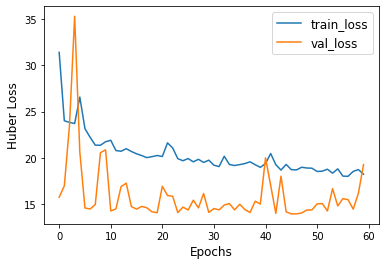

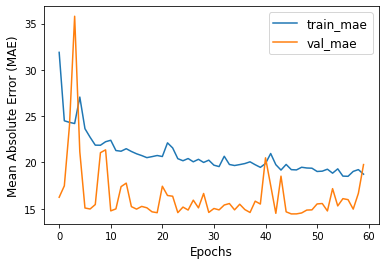

In [146]:
## Plotting training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Huber Loss', fontsize=12)

## Plotting training and validation MAE metric
plt.figure()
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)

Mean Absolute Error on the validation set =  19.859785


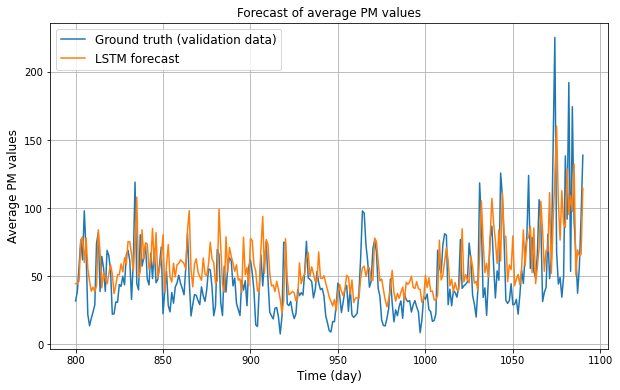

In [147]:
## Using model predictions to forecast the values in the validation set
lstm_forecast = model_forecast(model, series_avg_d[..., np.newaxis], window_size)
lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]

## Plotting model forecast against validation set
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, label='Ground truth (validation data)')
plt.plot(time_valid, lstm_forecast, label='LSTM forecast')
plt.legend(fontsize=12)
plt.grid()
plt.title('Forecast of average PM values', fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('Average PM values', fontsize=12)

mae_value_on_forecast = tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()
print('Mean Absolute Error on the validation set = ', mae_value_on_forecast)

In [150]:
pm_threshold = 100
print('No. of days when PM value is forecast to be above given threshold: ', np.where(lstm_forecast > pm_threshold)[0].shape, ' days')
print('No. of days when PM value in ground truth is above given threshold: ', np.where(series_avg_d[split_time:] > pm_threshold)[0].shape, ' days')

No. of days when PM value is forecast to be above given threshold:  (14,)  days
No. of days when PM value in ground truth is above given threshold:  (12,)  days




---



In [151]:
# Loading Shenyang data
fpath = '.'
city = 'Shenyang'
data = pd.read_csv(fpath+'/ShenyangPM20100101_20151231.csv')
data2 = pd.read_csv(fpath+'/ShenyangPM20100101_20151231.csv')
print(data.info())
print('\n')
print(data.isnull().sum())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             52584 non-null  int64  
 1   year           52584 non-null  int64  
 2   month          52584 non-null  int64  
 3   day            52584 non-null  int64  
 4   hour           52584 non-null  int64  
 5   season         52584 non-null  int64  
 6   PM_Taiyuanjie  24388 non-null  float64
 7   PM_US Post     21680 non-null  float64
 8   PM_Xiaoheyan   24627 non-null  float64
 9   DEWP           51892 non-null  float64
 10  HUMI           51904 non-null  float64
 11  PRES           51892 non-null  float64
 12  TEMP           51892 non-null  float64
 13  cbwd           51892 non-null  object 
 14  Iws            51892 non-null  float64
 15  precipitation  39821 non-null  float64
 16  Iprec          39821 non-null  float64
dtypes: float64(10), int64(6), object(1)
memory usage: 

,No,year,month,day,hour,season,PM_Taiyuanjie,PM_US Post,PM_Xiaoheyan,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,-26.0,69.79,1024.0,-22.0,NE,1.0289,NaN,NaN
1,2,2010,1,1,1,4,NaN,NaN,NaN,-26.0,76.26,1024.0,-23.0,NE,2.5722,NaN,NaN
2,3,2010,1,1,2,4,NaN,NaN,NaN,-27.0,69.56,1023.0,-23.0,NE,5.1444,NaN,NaN
3,4,2010,1,1,3,4,NaN,NaN,NaN,-27.0,69.56,1023.0,-23.0,NE,7.7166,NaN,NaN
4,5,2010,1,1,4,4,NaN,NaN,NaN,-27.0,69.56,1022.0,-23.0,NE,9.7744,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,52580,2015,12,31,19,4,162.0,166.0,435.0,-10.0,92.42,1031.0,-9.0,SE,2.0000,0.0,0.0
52580,52581,2015,12,31,20,4,255.0,259.0,429.0,-10.0,79.10,1030.0,-7.0,SE,5.0000,0.0,0.0
52581,52582,2015,12,31,21,4,266.0,368.0,361.0,-10.0,79.10,1030.0,-7.0,SE,8.0000,0.0,0.0
52582,52583,2015,12,31,22,4,202.0,319.0,342.0,-10.0,79.10,1028.0,-7.0,SE,11.0000,NaN,NaN


No handles with labels found to put in legend.


Checking for NaNs before imputing

No                   0
year                 0
month                0
day                  0
hour                 0
season               0
PM_Taiyuanjie    28196
PM_US Post       30904
PM_Xiaoheyan     27957
DEWP               692
HUMI               680
PRES               692
TEMP               692
cbwd               692
Iws                692
precipitation    12763
Iprec            12763
dtype: int64
Checking for NaNs after imputing

No                 0
year               0
month              0
day                0
hour               0
season             0
PM_Taiyuanjie      0
PM_US Post         0
PM_Xiaoheyan       0
DEWP               0
HUMI               0
PRES               0
TEMP               0
cbwd             692
Iws                0
precipitation      0
Iprec              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
--- 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

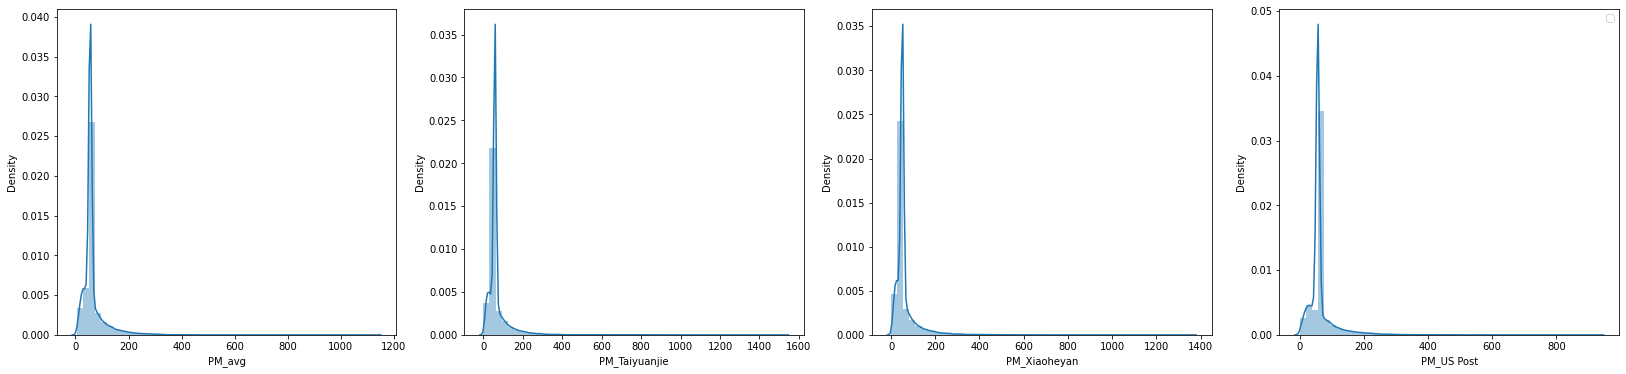

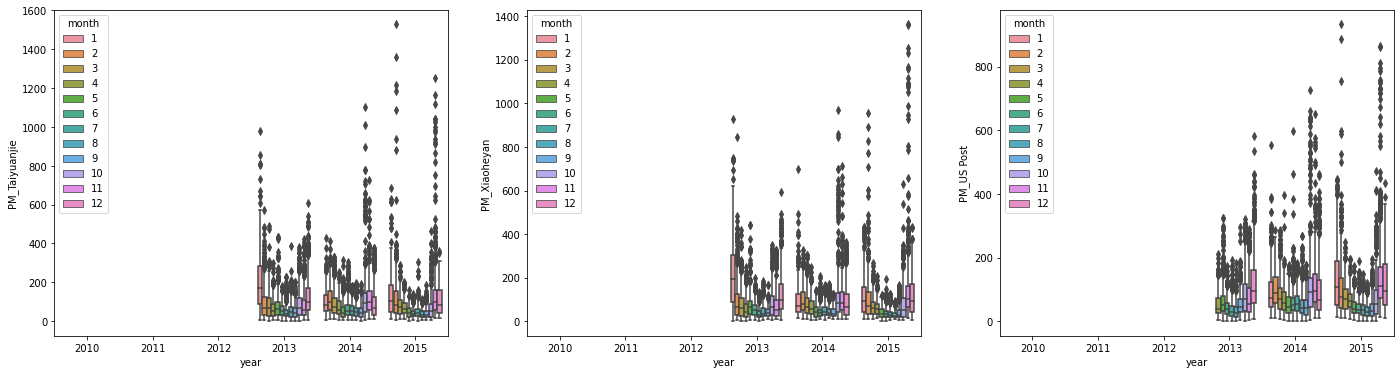

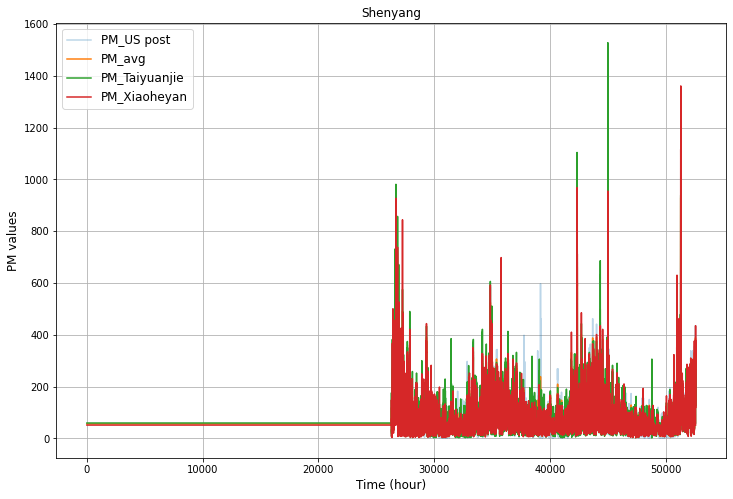

In [152]:
# Imputing missing PM values with medians
pm_list = ['PM_Taiyuanjie','PM_Xiaoheyan','PM_US Post']
print('Checking for NaNs before imputing\n')
print(data.isnull().sum())
data2 = impute_data_median(data2, pm_list)
print('Checking for NaNs after imputing\n')
print(data2.isnull().sum())

# Adding an average PM column by averaging over all PM columns
data2 = average_PM(data2, pm_list)
data2.info()

# Distribution plot visualization PM values from Beijing data
dist_plot_visualization(data2, pm_list)

# Box plot visualization PM values by the month before imputing
box_plot_visualization(data,pm_list,hue='month')

## Plotting all PM time series
plot_PM_time_series(data2, pm_list, xlabel='Time (hour)', ylabel='PM values', title=city)

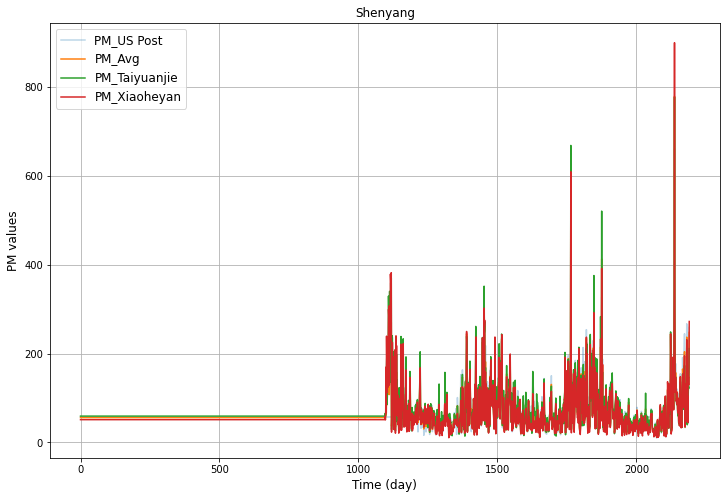

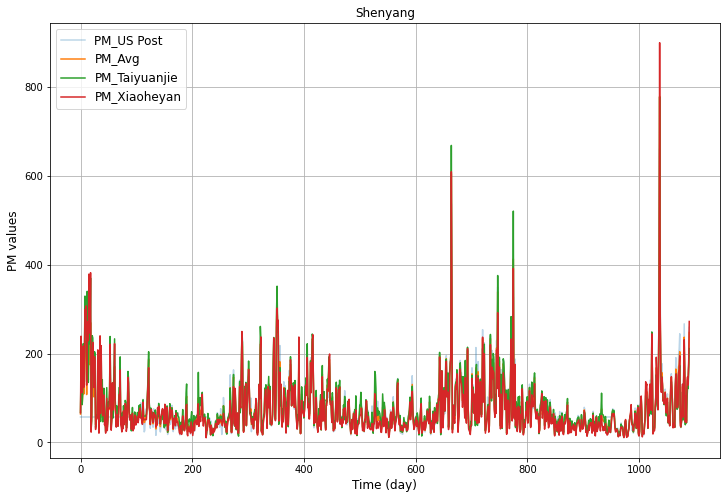

In [153]:
# Averaging PM values over 24 hours in a day
## Extracting PM values to corresponding arrays
series_avg = np.array(data2['PM_avg'])
series_US_post = np.array(data2['PM_US Post'])
series_Taiyuanjie = np.array(data2['PM_Taiyuanjie'])
series_Xiaoheyan = np.array(data2['PM_Xiaoheyan'])
time = np.arange(len(series_avg),dtype=int)

## PM values avergaed over a day
series_avg_d = average_hour(series_avg, 24)
series_US_post_d = average_hour(series_US_post, 24)
series_Taiyuanjie_d = average_hour(series_Taiyuanjie, 24)
series_Xiaoheyan_d = average_hour(series_Xiaoheyan, 24)
time_d = np.arange(len(series_avg_d),dtype=int)

## Plotting PM values averaged over a day as a time series
plt.figure(figsize=(12,8))
plt.plot(time_d, series_US_post_d, label='PM_US Post',alpha=0.3)
plt.plot(time_d, series_avg_d, label='PM_Avg')
plt.plot(time_d, series_Taiyuanjie_d, label='PM_Taiyuanjie')
plt.plot(time_d, series_Xiaoheyan_d, label='PM_Xiaoheyan')
plt.legend(fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('PM values', fontsize=12)
plt.title(city, fontsize=12)
plt.grid()

## Using PM values only from the later period
start = 1100
series_US_post_d = series_US_post_d[start:]
series_avg_d = series_avg_d[start:]
series_Taiyuanjie_d = series_Taiyuanjie_d[start:]
series_Xiaoheyan_d = series_Xiaoheyan_d[start:]
time_d = np.arange(len(series_avg_d))
## Plotting PM values for the later period
plt.figure(figsize=(12,8))
plt.plot(time_d, series_US_post_d, label='PM_US Post',alpha=0.3)
plt.plot(time_d, series_avg_d, label='PM_Avg')
plt.plot(time_d, series_Taiyuanjie_d, label='PM_Taiyuanjie')
plt.plot(time_d, series_Xiaoheyan_d, label='PM_Xiaoheyan')
plt.legend(fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('PM values', fontsize=12)
plt.title(city, fontsize=12)
plt.grid()

In [154]:
# Preparing the training-validation dataset
split_time = 800 
time_train = time_d[:split_time]
x_train = series_avg_d[:split_time]
time_valid = time_d[split_time:]
x_valid = series_avg_d[split_time:]

## Setting some hyperparameters for batching the window data which is fed into
## the model
window_size = 30
batch_size = 32
shuffle_buffer_size = split_time

## Getting the training and validation set
## Training set
tf.keras.backend.clear_session()
tf.random.set_seed(101)
np.random.seed(101)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)
## Validation set
shuffle_buffer_size = len(series_avg_d) - split_time
test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(test_set)
print(x_valid.shape)

## Instantiating the LSTM model
model = lstm_model(num_filters=50, num_lsunits=[60, 60], num_dunits=30)

## Compiling the model using Huber loss and SGD optimizer and MAE metric for accuracy
optimizer = tf.keras.optimizers.SGD(lr=8e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]
              )

## Training the model
history = model.fit(train_set,epochs=60, validation_data=test_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(800,)
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(291,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/60
25/25 [==============================] - 6s 84ms/step - loss: 41.5536 - mae: 42.0508 - val_loss: 29.1095 - val_mae: 29.6056
Epoch 2/60
25/25 [==============================] - 1s 43ms/step - loss: 33.3087 - mae: 33.8040 - val_loss: 44.9290 - val_mae: 45.4275
Epoch 3/60
25/25 [==============================] - 1s 45ms/step - loss: 34.2451 - mae: 34.7408 - val_loss: 31.3763 - val_mae: 31.8744
Epoch 4/60
25/25 [==============================] - 1s 44ms/step - loss: 31.4149 - mae: 31.9108 - val_loss: 48.5216 - val_mae: 49.0213
Epoch 5/60
25/25 [==============================] - 1s 45ms/step - loss: 36.7142 - mae: 37.2109 - val_loss: 37.3863 - val_mae: 37.8835
Epoch 6/60
25/25 [==============================] - 1s 44ms/step - loss: 32.3837 - mae: 32.8794 - val_loss: 26.5131 - val_mae: 27.0086
Epoch 7/60
25/25 [==============================] - 1s 44ms/step - loss: 30.8015 - mae: 31.2969 - val_loss: 27.6555 - val_mae: 28.1510
Epoch 8/60
25/25 [==============================] - 1s 

Text(0, 0.5, 'Mean Absolute Error (MAE)')

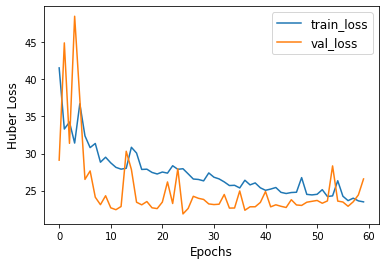

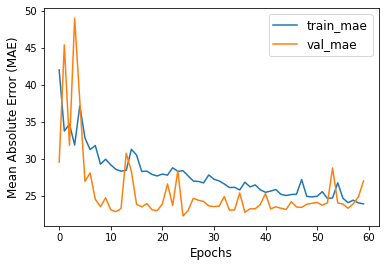

In [155]:
## Plotting training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Huber Loss', fontsize=12)

## Plotting training and validation MAE metric
plt.figure()
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)

Mean Absolute Error on the validation set =  29.373514


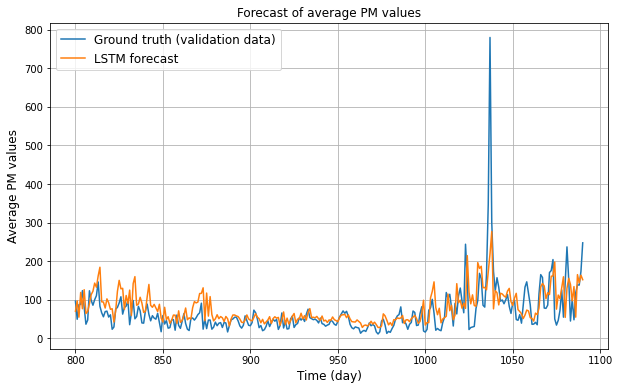

In [156]:
## Using model predictions to forecast the values in the validation set
lstm_forecast = model_forecast(model, series_avg_d[..., np.newaxis], window_size)
lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]

## Plotting model forecast against validation set
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, label='Ground truth (validation data)')
plt.plot(time_valid, lstm_forecast, label='LSTM forecast')
plt.legend(fontsize=12)
plt.grid()
plt.title('Forecast of average PM values', fontsize=12)
plt.xlabel('Time (day)', fontsize=12)
plt.ylabel('Average PM values', fontsize=12)

mae_value_on_forecast = tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()
print('Mean Absolute Error on the validation set = ', mae_value_on_forecast)

In [158]:
pm_threshold = 150
print('No. of days when PM value is forecast to be above given threshold: ', np.where(lstm_forecast > pm_threshold)[0].shape, ' days')
print('No. of days when PM value in ground truth is above given threshold: ', np.where(series_avg_d[split_time:] > pm_threshold)[0].shape, ' days')

No. of days when PM value is forecast to be above given threshold:  (19,)  days
No. of days when PM value in ground truth is above given threshold:  (19,)  days




---



**Problem 2 - Algorithm Comparison**
A painter has N paintings that he wants to give as a gift to each one of his M clients from his art gallery. The painter has an idea of the client's tastes and can estimate their fondness for each painting with a score of 0.0 to 1.0. To best satisfy the clients, the painter wants to select the client-painting pairs that will maximize the total fondness. For this question, please benchmark at least two different algorithms for solving (or approximately solving) this assignment problem.
 
Details:
* Generate a random float array to perform tests.
* The matching is 1 to 1, so one customer is matched to one unique painting.
* Consider and/or discuss, runtime, memory complexity as N and M increase (start small but test up to at least ~1000 x 3000 size).
* Consider tradeoffs between speed and accuracy between any approximate and explicit solutions.
* Heuristic approximations are fair game, hill climber, genetic algorithms, annealing, etc., can all be considered.
Please provide a Jupyter notebook showing the analysis, a brief write-up of findings, and any relevant visualizations.

**Solution**
This is essentially an assignment/matching problem which can be solved using a number of approaches. I am considering here the following 2 algorithms

* Naive algorithm where a random element is picked in each row, this doesn't guarantee 1-1 mapping, but just used as a reference
* Linear sum assignment, which has O(N^3) scaling

In [225]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import maximum_bipartite_matching
import time

In [227]:
def random_pick(fondness):
  col_ind = []
  sum = 0.
  N = fondness.shape[0]
  M = fondness.shape[1]
  for i in range(N):
    j = np.random.randint(low=0,high=M-1)
    col_ind.append(j)
    sum += fondness[i,j]

  return sum, col_ind

def linear_assignment(fondness):
  row_ind, col_ind = linear_sum_assignment(fondness, maximize=True)
  sum = fondness[row_ind, col_ind].sum()

  return sum, col_ind

In [221]:
N = 4
M = 6
fondness = np.random.random((N,M))
print(fondness)

[[0.74781136 0.52905775 0.8444134  0.4988666  0.26617854 0.13567143]
 [0.43112058 0.34208453 0.98221813 0.11817561 0.95812261 0.28181087]
 [0.89155596 0.85200885 0.82765709 0.95639403 0.77073883 0.32901855]
 [0.41834248 0.28774208 0.97821434 0.15401552 0.67079557 0.93506918]]


In [222]:
sum_ln, col_ind_ln = linear_assignment(fondness)
sum_rnd, col_ind_rnd = random_pick(fondness)
print(sum_ln, sum_rnd)

3.693999220395827 2.388147596662411


In [223]:
N = 400
M = 600
fondness = np.random.random((N,M))

sum_ln, col_ind_ln = linear_assignment(fondness)
sum_rnd, col_ind_rnd = random_pick(fondness)
print(sum_ln, sum_rnd)

399.13173648927136 203.62871526884678


In [224]:
Nv = np.logspace(start=1, stop=3, num=10, dtype=int)
Mv = 3*Nv
print(Nv)
print(Mv)

[  10   16   27   46   77  129  215  359  599 1000]
[  30   48   81  138  231  387  645 1077 1797 3000]


In [230]:
time_linear = []
time_random = []
sum_linear = []
sum_random = []
for ix in range(len(Nv)):
    fondness = np.random.random((Nv[ix],Mv[ix]))

    t1 = time.time()
    sum_ln, col_ind_ln = linear_assignment(fondness)
    t2 = time.time() - t1
    time_linear.append(t2)

    t1 = time.time()
    sum_rnd, col_ind_rnd = random_pick(fondness)
    t2 = time.time() - t1
    time_random.append(t2)

    sum_linear.append(sum_ln)
    sum_random.append(sum_rnd)
    print(Nv[ix],Mv[ix])

10 30
16 48
27 81
46 138
77 231
129 387
215 645
359 1077
599 1797
1000 3000


Text(0, 0.5, 'Time (sec)')

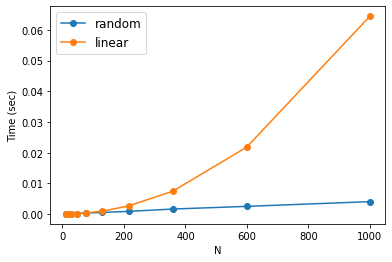

In [234]:
plt.plot(Nv, time_random, '-o', label='random')
plt.plot(Nv, time_linear, '-o', label='linear')
plt.legend(fontsize=12)
plt.xlabel('N')
plt.ylabel('Time (sec)')